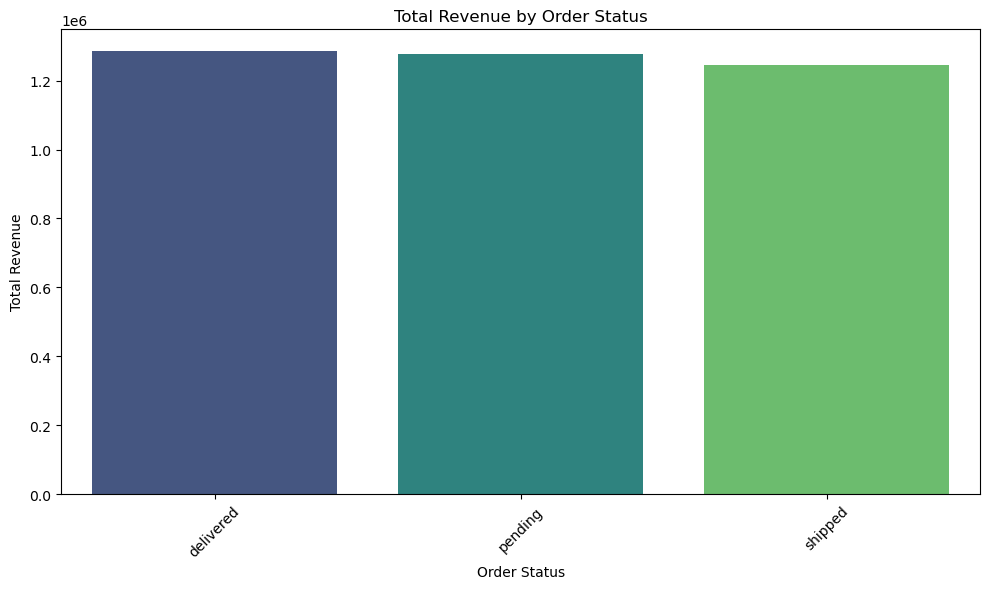

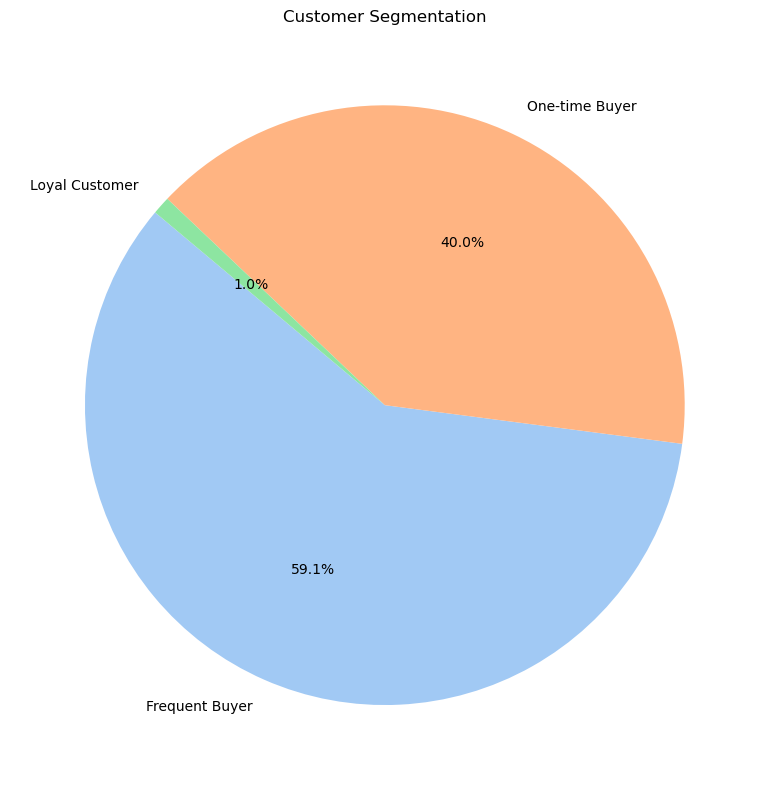

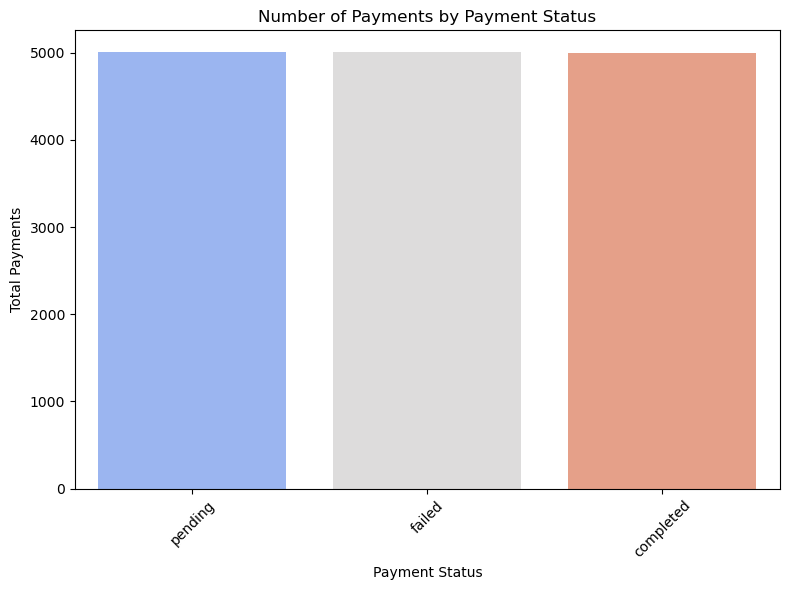

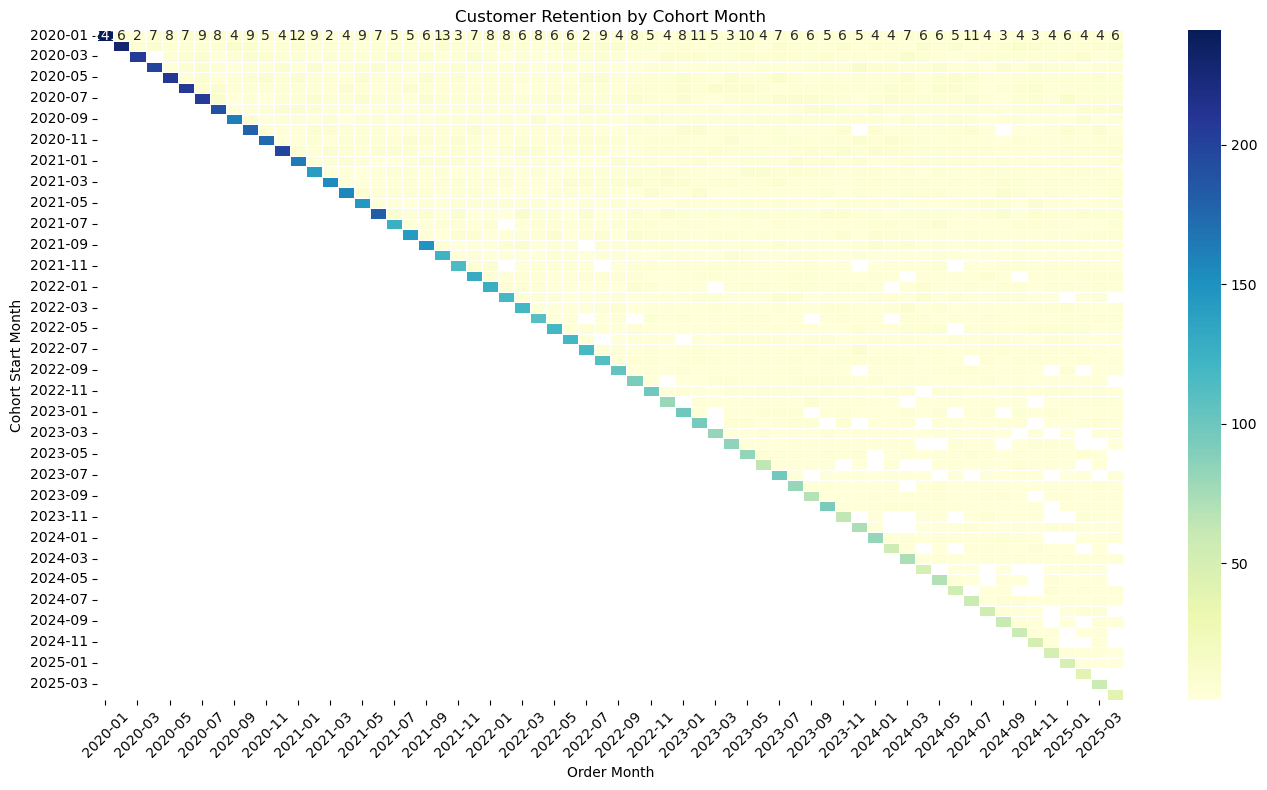

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# --- Load Data from CSVs ---
orders = pd.read_csv('customer_orders.csv')
payments = pd.read_csv('payments.csv')

# --- Setup SQLite DB ---
conn = sqlite3.connect('altmobility.db')
orders.to_sql('customer_orders', conn, if_exists='replace', index=False)
payments.to_sql('payments', conn, if_exists='replace', index=False)

# --- Task 1: Order and Sales Analysis ---

query_order_sales = """
SELECT 
    order_status,
    COUNT(order_id) AS total_orders,
    SUM(order_amount) AS total_revenue,
    AVG(order_amount) AS avg_order_value
FROM 
    customer_orders
GROUP BY 
    order_status
ORDER BY 
    total_revenue DESC;
"""
order_sales_df = pd.read_sql_query(query_order_sales, conn)

# Visualization 1: Bar Chart (Order Status vs Total Revenue)
plt.figure(figsize=(10,6))
sns.barplot(data=order_sales_df, x='order_status', y='total_revenue', palette='viridis')
plt.title('Total Revenue by Order Status')
plt.xlabel('Order Status')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('order_sales_analysis.png')
plt.show()

# --- Task 2: Customer Analysis ---

query_customer_analysis = """
WITH customer_summary AS (
    SELECT
        customer_id,
        COUNT(order_id) AS total_orders,
        SUM(order_amount) AS total_spent
    FROM
        customer_orders
    GROUP BY
        customer_id
)
SELECT 
    customer_id,
    total_orders,
    total_spent,
    CASE 
        WHEN total_orders = 1 THEN 'One-time Buyer'
        WHEN total_orders BETWEEN 2 AND 5 THEN 'Frequent Buyer'
        ELSE 'Loyal Customer'
    END AS customer_segment
FROM 
    customer_summary
ORDER BY 
    total_spent DESC;
"""
customer_analysis_df = pd.read_sql_query(query_customer_analysis, conn)

# Visualization 2: Pie Chart (Customer Segments)
segment_counts = customer_analysis_df['customer_segment'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Customer Segmentation')
plt.tight_layout()
plt.savefig('customer_segmentation.png')
plt.show()

# --- Task 3: Payment Status Analysis ---

query_payment_status = """
SELECT
    payment_status,
    COUNT(payment_id) AS total_payments,
    SUM(payment_amount) AS total_amount
FROM
    payments
GROUP BY
    payment_status
ORDER BY
    total_payments DESC;
"""
payment_status_df = pd.read_sql_query(query_payment_status, conn)

# Visualization 3: Bar Chart (Payment Status Counts)
plt.figure(figsize=(8,6))
sns.barplot(data=payment_status_df, x='payment_status', y='total_payments', palette='coolwarm')
plt.title('Number of Payments by Payment Status')
plt.xlabel('Payment Status')
plt.ylabel('Total Payments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('payment_status_analysis.png')
plt.show()

# --- Task 4: Order Details Report ---
# (No visualization needed — it's a detailed table report.)
order_details_query = """
SELECT
    o.order_id,
    o.customer_id,
    o.order_date,
    o.order_amount,
    o.order_status,
    p.payment_id,
    p.payment_date,
    p.payment_amount,
    p.payment_status
FROM
    customer_orders o
LEFT JOIN
    payments p
ON
    o.order_id = p.order_id
ORDER BY
    o.order_date;
"""
order_details_df = pd.read_sql_query(order_details_query, conn)
order_details_df.head(10)  # display sample

# --- Task 5: Customer Retention (Cohort Analysis) ---

# Prepare Cohort Matrix
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['order_month'] = orders['order_date'].dt.to_period('M')
orders['first_order_month'] = orders.groupby('customer_id')['order_date'].transform('min').dt.to_period('M')

cohort_data = orders.groupby(['first_order_month', 'order_month']).agg(n_customers=('customer_id', 'nunique')).reset_index()
cohort_pivot = cohort_data.pivot(index='first_order_month', columns='order_month', values='n_customers')

# Visualization 5: Cohort Heatmap
plt.figure(figsize=(14,8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('Customer Retention by Cohort Month')
plt.xlabel('Order Month')
plt.ylabel('Cohort Start Month')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cohort_retention_heatmap.png')
plt.show()
